<a href="https://colab.research.google.com/github/sayakpaul/Generalized-ODIN-TF/blob/main/Evaluation_OOD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
# Retrieve the pre-trained ResNet20 model.
# Refer to this notebook for details: https://git.io/JOJuL.
!gdown --id 1-6Xp7__VMJeMBtGMByI7_GYVeIIv-1Ay -O odin_rn_model.tar.gz
!tar xf odin_rn_model.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1-6Xp7__VMJeMBtGMByI7_GYVeIIv-1Ay
To: /content/odin_rn_model.tar.gz
6.62MB [00:00, 58.1MB/s]


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(42)
np.random.seed(42)
tfds.disable_progress_bar()

## Load the pre-trained model

In [2]:
model = tf.keras.models.load_model("odin_rn_model")
print(f"Pre-trained model loaded with {model.count_params()/1e6} M parameters.")

Pre-trained model loaded with 0.572223 M parameters.


## Load OOD dataset -- SVHN dataset

The purpose of this work is to test a model's ability to detect out-of-distribution (OOD) samples. For that purpose, we are using the [SVHN dataset](https://http://ufldl.stanford.edu/housenumbers/) which is an OOD dataset in this case. 

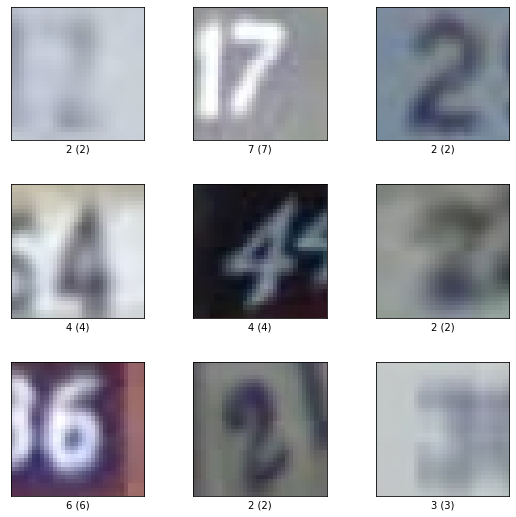

Total examples in the test set of SVHN: 26032


In [3]:
shvn_test, info = tfds.load("svhn_cropped", split="test", 
                      as_supervised=True, with_info=True)
tfds.show_examples(shvn_test, info)
print(f"Total examples in the test set of SVHN: {tf.data.experimental.cardinality(shvn_test).numpy()}")

## Prepare the data loaders

In [4]:
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE

In [5]:
shvn_test = (shvn_test
             .batch(BATCH_SIZE, drop_remainder=True)
             .map(lambda x, y: (tf.cast(x, tf.float32), y), 
                  num_parallel_calls=AUTO)
             .prefetch(AUTO))

## Define our `scorer`

In [6]:
# Let's define our model to obtain scores.
scorer = tf.keras.Model(model.input, model.layers[-3].output)

In [7]:
# We can take a batch of data and obtain the OOD scores like so.
logits = scorer.predict(shvn_test.take(1))
tf.reduce_max(logits, axis=1)[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([1.6719896, 1.9103596, 5.412668 , 2.9244256, 1.746513 ],
      dtype=float32)>

## Perturbing utility

As per equation 9 of the paper, we will be perturbing the input images with $\epsilon$ which was calculated in [this notebook](https://git.io/JOTgx). The value we derived is **0.08**. 

In [8]:
def perturb_images(images, model, epsilon=0.08):
    test_ds_var = tf.Variable(images, trainable=True)
    
    with tf.GradientTape() as tape:
        # Calculate the scores.
        tape.watch(test_ds_var)
        logits = model(test_ds_var, training=False)
        scores = tf.reduce_max(logits, axis=1)

    # Calculate the gradients of the scores with respect to the inputs.
    # (Notice the sign.)
    gradients = -tape.gradient(scores, test_ds_var)

    # Perturb the inputs and derive new mean score.
    test_ds_var.assign_sub(epsilon * tf.sign(gradients))
    static_tensor = tf.convert_to_tensor(test_ds_var)

    return static_tensor

## Model evalution with AUROC

The authors use two metrics for evaluation -- **AUROC** & **TNR@TPR95**. In this notebook, we will only use AUROC. 

Here are the steps we will roughly be following:

1. Perturb the images using `perturb_images()`. For this, we will be using `scorer`. 
2. Pass those images to `model` to obtain predictions. From the paper - "At testing time, the class prediction can be made by either calculating $\arg \max _{i} f_{i}(\boldsymbol{x})$ or
$\arg \max _{i} h_{i}(\boldsymbol{x})$ (both will give the same predictions)."
3. Use the original labels of the dataset under evaluation and the prediction scores from (2) and calculate the AUROC. 

In [9]:
roc_auc_all = []

for images, labels in shvn_test:
    pertubed_images = perturb_images(images, scorer)
    
    logits = model.predict(pertubed_images)
    predictions = tf.nn.softmax(logits, 1)
    roc_auc_batch = roc_auc_score(labels.numpy(), predictions.numpy(), multi_class="ovr")
    roc_auc_all.append(roc_auc_batch)

print(f"Mean AUROC: {np.mean(roc_auc_all)}")

Mean AUROC: 0.52235275780662
